In [1]:
from datetime import datetime, timedelta
from dateutil import parser, zoneinfo, tz
from collections import defaultdict
from copy import deepcopy
from operator import itemgetter
import pandas as pd
import numpy as np
from queue import Queue
import math
import statistics
import random
import pytz
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set_style('whitegrid')

# Ignore harmless warnings 
import warnings 
warnings.filterwarnings("ignore") 

In [2]:
# !pip install haversine
from haversine import haversine, Unit

In [3]:
charging_speed = 10
charging_fee = 9
parking_slots_num = 10
ALPHA = 0.5

In [4]:
building_start_time = parser.parse("2018-07-01")
building_end_time = parser.parse("2018-07-08")
charging_start_time = parser.parse("2018-07-01")
charging_end_time = parser.parse("2018-07-08")

In [6]:
building_data = pd.read_csv("./Dataset/generation_with_consumption_3.csv", index_col=0)
building_LSTM_data = pd.read_csv("./Result/predict_building_data.csv", index_col=0)
charging_data = pd.read_csv("./Dataset/charging_data_2_move.csv")

building_data["datetime"] = pd.to_datetime(building_data["datetime"], format="%Y-%m-%d %H:%M:%S")
building_data["buildingID"] = building_data["buildingID"].astype(str)

building_LSTM_data["datetime"] = pd.to_datetime(building_LSTM_data["datetime"], format="%Y-%m-%d %H:%M:%S")
building_LSTM_data["buildingID"] = building_LSTM_data["buildingID"].astype(str)

charging_data["createdNew"] = pd.to_datetime(charging_data["createdNew"], format="%Y-%m-%d %H:%M:%S")
charging_data["locationId"] = charging_data["locationId"].astype(str)
charging_data["userId"] = charging_data["userId"].astype(str)

building_data.loc[building_data["buildingID"] == "13", "contract_capacity"] = 222
building_data.loc[building_data["buildingID"] == "10", "contract_capacity"] = 273

In [5]:
# location = pd.read_csv("./Dataset/Simulation/location_5.csv", index_col="locationId")
location = pd.read_csv("./Dataset/location_5.csv", index_col="locationId")
location.index = location.index.astype(str) # 將索引轉換為字串型態
location = location.sort_values(by="buildingID") # 以 "buildingID" 這個欄位為鍵進行排序。
location["buildingID"] = location["buildingID"].astype(str) # 將 "buildingID" 這個欄位轉換為字串型態。

location.loc["50911", "contractCapacity"] = 222 #13
location.loc["50266", "contractCapacity"] = 273 #10
location

,Unnamed: 0,Latitude,Longitude,Location,Typing,Business_Time,buildingID,FacilityType,stationNewNum,stationUpperElec,contractCapacity,budget
locationId,,,,,,,,,,,,
50230,12,56.472968,-3.002456,Marchbanks,grocery,0800-2100,0,2,10,100,236,30
51199,4,56.460112,-2.975760,Dundee House,restaurant,1200-2100,1,3,10,100,204,43
50841,3,56.470163,-2.920664,Brington Place Sheltered Housing,grocery,0800-2200,2,2,10,100,415,45
50692,2,56.482148,-3.024697,Dundee Ice Arena,leisure,1000-1600,3,4,10,100,173,40
51087,18,56.467775,-2.873361,Queen Street Car Park,coffee,0800-1800,4,1,10,100,183,44
51198,6,56.460164,-2.975911,Dundee House,restaurant,0800-2400,5,3,10,100,212,39
50840,0,56.488382,-3.014353,Ardler Complex,leisure,0800-2000,6,4,10,100,175,45
50349,9,56.456726,-2.973511,Greenmarket Car Park,restaurant,1300-2200,7,3,10,100,394,30
50909,11,56.459078,-2.977268,South Tay Street,leisure,0900-1700,8,4,10,100,237,34


In [7]:
def calculate_electricity_price(location, locationID, info):

    testing_start_time = charging_start_time
    each_building_price = 262.5
    capacity_price = 236.2
    contract_capacity = location.loc[locationID, "contractCapacity"]
    electricity_price = defaultdict()

    for weekday in range(1, 8):
        if weekday < 6:
            electricity_price[weekday] = [1.46] * 7 + [3.42] * 15 + [1.46] * 2
        elif weekday == 6:
            electricity_price[weekday] = [1.46] * 7 + [2.14] * 15 + [1.46] * 2
        else:
            electricity_price[weekday] = [1.46] * 24
    
    ### 基本電費 ###
    basic_tariff = each_building_price + (capacity_price * contract_capacity)

    ### 流動電費 ###
    current_tariff = 0
    for day in range(1, 8):
        weekday = testing_start_time.isoweekday()
        for hour in range(24):
            current_tariff += electricity_price[weekday][hour] * (info[info["datetime"] == testing_start_time]["total"].values[0])
            testing_start_time += timedelta(hours=1)
    
    ### 超約罰金 ###
    overload_penalty = 0
    overload = info["total"].max()
    
    if max(overload, contract_capacity) != contract_capacity:
        overload -= contract_capacity
        overload_penalty += min(overload, contract_capacity * 0.1) * capacity_price * 2
        overload -= min(overload, contract_capacity * 0.1)
        overload_penalty += overload * capacity_price * 3

    return basic_tariff, current_tariff, overload_penalty

In [8]:
def get_charging_request(charging_data, date):
    
    request_df = charging_data[(charging_data["createdNew"] >= date) & ((charging_data["createdNew"] < (date + timedelta(days=1))))]
    request_df["chargingHour"] = request_df["kwhNew"].apply(lambda x: x / charging_speed)
    charging_request = list()
 
    for item in request_df.iterrows():
        request = list(item[1][["_id", "userId", "chargingHour", "createdHour", "locationId"]])
        charging_request.append(request)

    return charging_request

In [9]:
truth_data = building_data.copy()
truth_data = truth_data.loc[(truth_data["datetime"] >= charging_start_time) & (truth_data["datetime"] < charging_end_time)]
truth_data

for idx, row in truth_data.iterrows():

    max_station_num = location[location["buildingID"] == row["buildingID"]]["stationNewNum"].values[0]
    parking_slots = math.floor((row["contract_capacity"] - row["consumption"] + row["generation"]) / charging_speed)

    parking_slots = max(min(max_station_num, parking_slots), 0)
    truth_data.loc[idx, "parkingSlots"] = parking_slots

truth_data

,originID,buildingID,datetime,consumption,timestamp,generation,contract_capacity,parkingSlots
4344,281,0,2018-07-01 00:00:00,134.5124,1.609250e+10,0.001251,236,10.0
4345,281,0,2018-07-01 01:00:00,131.9056,1.609254e+10,0.001150,236,10.0
4346,281,0,2018-07-01 02:00:00,125.3885,1.609258e+10,0.001044,236,10.0
4347,281,0,2018-07-01 03:00:00,137.9011,1.609262e+10,0.000988,236,9.0
4348,281,0,2018-07-01 04:00:00,136.8584,1.609267e+10,0.001222,236,9.0
...,...,...,...,...,...,...,...,...
170947,512,19,2018-07-07 19:00:00,260.4630,1.609954e+10,3.030326,343,8.0
170948,512,19,2018-07-07 20:00:00,255.1878,1.609958e+10,1.871092,343,8.0
170949,512,19,2018-07-07 21:00:00,256.1769,1.609962e+10,0.872153,343,8.0
170950,512,19,2018-07-07 22:00:00,247.2750,1.609967e+10,0.382687,343,9.0


In [10]:
def get_user_list(date):
    temp = charging_data[charging_data["createdNew"] < date]
    user_list = temp.groupby("userId").groups.keys()
    return user_list

In [11]:
def get_parking_slots(building_data, location, date):
    ### LSTM ###

    electricity = building_data[ (building_data["datetime"] >= date) & (building_data["datetime"] < date + timedelta(days=1)) ]
    for idx, row in electricity.iterrows():
        contract_capacity = location[location["buildingID"] == row["buildingID"]]["contractCapacity"].values[0]
        max_station_num = location[location["buildingID"] == row["buildingID"]]["stationNewNum"].values[0]
        parking_slots = math.floor((contract_capacity - row["consumption"] + row["generation"]) / charging_speed)
        parking_slots = parking_slots if parking_slots < max_station_num else max_station_num
        electricity.loc[idx, "parkingSlots"] = parking_slots
    electricity["parkingSlots"] = electricity["parkingSlots"].apply(lambda x: math.floor(x) if x > 0 else 0)

    return electricity


def get_residual_slots(location, building_info, cs, hour, charging_len, schedule_type="OMMKP"):
    df = building_info.loc[(building_info["buildingID"] == location.loc[cs, "buildingID"]) & 
                           (building_info["datetime"].dt.hour >= hour) &
                           (building_info["datetime"].dt.hour < (hour + charging_len))]

    if schedule_type == "popular":
        return df["parkingSlots"].values[0] if df["parkingSlots"].all() else 0

    ### 保留一個充電位 ###
    df["parkingSlots"] = df["parkingSlots"].apply(lambda x: 0 if (x-1) < 0 else (x-1))
    return df["parkingSlots"].values[0] if df["parkingSlots"].all() else 0
    # return df["parkingSlots"].values[0] if (df["parkingSlots"].all() and df["parkingSlots"].values[0] > 1) else 0


def update_user_selection(location, slots_df, date, schedule, charging_len):

    slots_df.loc[(slots_df["buildingID"] == location.loc[schedule[0], "buildingID"]) &
                 (slots_df["datetime"] >= (date + timedelta(hours = schedule[1]))) &
                 (slots_df["datetime"] < (date + timedelta(hours = schedule[1] + charging_len))), "parkingSlots"] -= 1

    return slots_df

# MISP_v2

In [15]:
schedule_df = pd.DataFrame([], columns=["datetime", "date", "userID", "locationID", "buildingID", "chargingLen", "originLocationID", "originChargingHour", "incentive", "score"])
testing_start_time = charging_start_time
null_value = 0

for day in range(7):
    charging_request = get_charging_request(charging_data, testing_start_time)
    # recommend = pd.read_csv(f"./Result/Schedule/MultipleStation/MISP/0719_expected_score_6/alpha_0.5/{testing_start_time.strftime('%m%d')}.csv")
    recommend = pd.read_csv(f"./Result/MISP_v2/2023_05_03_refactor/alpha_0.5/5/{testing_start_time.strftime('%m%d')}.csv")
    recommend["datetime"] = pd.to_datetime(recommend["datetime"], format="%Y-%m-%d %H:%M:%S")
    
    for request in charging_request:
        try:
            schedule = recommend[recommend["requestID"] == request[0]]
            schedule_df.loc[len(schedule_df)] = [schedule["datetime"].values[0],
                                                testing_start_time.strftime("%m%d"),
                                                schedule["userID"].values[0],
                                                str(schedule["locationID"].values[0]),
                                                location.loc[str(schedule["locationID"].values[0]), "buildingID"],
                                                schedule["chargingLen"].values[0],
                                                schedule["originLocationID"].values[0],
                                                schedule["originHour"].values[0],
                                                schedule["incentive"].values[0],
                                                schedule["score"].values[0]]
        except Exception as e:
            print(request, e)
            null_value += 1

    testing_start_time += timedelta(days=1)
    
schedule_df

[18851, '607224', 2.0, 19, '50911'] index 0 is out of bounds for axis 0 with size 0
[7099, '604800H', 2.0, 16, '50911'] index 0 is out of bounds for axis 0 with size 0
[12161, '605642', 2.0, 12, '51087'] index 0 is out of bounds for axis 0 with size 0
[11912, '603475', 3.0, 17, '50692'] index 0 is out of bounds for axis 0 with size 0
[11821, '607224', 1.0, 3, '50911'] index 0 is out of bounds for axis 0 with size 0
[11531, '607224', 1.0, 19, '50911'] index 0 is out of bounds for axis 0 with size 0
[11530, '607224', 3.0, 20, '50911'] index 0 is out of bounds for axis 0 with size 0
[11405, '604800H', 2.0, 14, '50911'] index 0 is out of bounds for axis 0 with size 0
[11336, '605642', 3.0, 21, '50911'] index 0 is out of bounds for axis 0 with size 0
[11193, '607670', 2.0, 15, '50911'] index 0 is out of bounds for axis 0 with size 0
[11134, '604800H', 2.0, 20, '50911'] index 0 is out of bounds for axis 0 with size 0
[11230, '605084H', 2.0, 13, '50911'] index 0 is out of bounds for axis 0 wi

,datetime,date,userID,locationID,buildingID,chargingLen,originLocationID,originChargingHour,incentive,score
0,2018-07-01 13:00:00,0701,606941,50268,19,3.0,51087,17,1,-1.000000
1,2018-07-01 12:00:00,0701,604897H,51200,15,1.0,51200,16,0,0.871882
2,2018-07-01 10:00:00,0701,604760H,50911,13,1.0,50240,17,0,0.565331
3,2018-07-01 10:00:00,0701,V009198,50268,19,2.0,50911,17,4,0.665496
4,2018-07-01 08:00:00,0701,604725H,50267,14,2.0,50261,16,1,-1.000000
...,...,...,...,...,...,...,...,...,...,...
719,2018-07-07 18:00:00,0707,604761H,50268,19,2.0,50349,12,1,0.295626
720,2018-07-07 18:00:00,0707,604900H,50269,12,2.0,50266,12,1,-1.000000
721,2018-07-07 15:00:00,0707,604745H,50675,18,2.0,51199,12,1,0.265521
722,2018-07-07 07:00:00,0707,603522H,50267,14,2.0,50911,12,3,0.357359


## Evaluation

P.45 Station Profits \\


變數 -> 論文內的名稱 \\
-------------------------------------------------------- \\
基本電費(basic_tariff) -> Basic Tariff \\
流動電費(current_tariff) -> Current Tariff \\
超約罰金(overload_penalty) -> Overage Penalty \\
收益(schedule_revenue) -> Revenue \\

In [16]:
overage = 0
electricity_price = pd.DataFrame([], columns=["basic_tariff", "current_tariff", "overload_penalty", "total"])
schedule_statistic_count = pd.DataFrame([], columns=[charging_start_time + timedelta(hours=hour) for hour in range(0, 7*24)])
overload_percentage = list()
schedule_revenue = defaultdict()
schedule_ev_charging_volume = list()
schedule_electricity_cost = defaultdict() 
schedule_ev_revenue = defaultdict()

for cs in location.index:
    info = building_data[ (building_data["buildingID"] == location.loc[cs, "buildingID"]) &  (building_data["datetime"] >= building_start_time) & (building_data["datetime"] < building_end_time) ]

    ### EV charging data ###
    ev_info = [0 for i in range(24*7)]
    current = charging_start_time
    for day in range(7):
        for hour in range(24):
            charging_value = len(schedule_df[(schedule_df["locationID"] == cs) &
                                             (schedule_df["datetime"] >= current) &
                                             (schedule_df["datetime"] < (current + timedelta(days=1))) &
                                             (schedule_df["datetime"].dt.hour <= hour) &
                                             ((schedule_df['datetime'].dt.hour + schedule_df["chargingLen"]) > hour)]) * charging_speed
            ev_info[(day * 24) + hour] = charging_value
        current += timedelta(days=1)

    schedule_ev_charging_volume.append(ev_info)
    schedule_ev_revenue[cs] = sum(ev_info) * charging_fee
    info["charging"] = ev_info
    info["total"] = info["consumption"] - info["generation"] + info["charging"]

    ### check number of exceed ###
    info["exceed"] = info["total"] - location.loc[cs, "contractCapacity"]
    info["exceed"] = info["exceed"].apply(lambda x: 0 if x < 0 else x)

    overload_slots = 0
    for raw in info["exceed"]:
        if raw != 0:
            overload_slots += 1
        # overload_slots += math.ceil(raw / charging_speed)

    overload_percentage.append(overload_slots / (7* 24))
    print(int(location.loc[cs, 'buildingID']), ":")
    print(f"overload = {'{:.2f}'.format(info['exceed'].sum())}")
    print(f"overload_percentage = {'{:.4f}'.format(overload_percentage[-1])}")
    
    overage += info["exceed"].sum()
    basic_tariff, current_tariff, overload_penalty = calculate_electricity_price(location, cs, info)
    total_price = basic_tariff + current_tariff + overload_penalty
    electricity_price.loc[len(electricity_price)] = [basic_tariff, current_tariff, overload_penalty, total_price]
    schedule_revenue[cs] = (-1) * total_price + (charging_fee * info["charging"].sum())
    schedule_electricity_cost[cs] = total_price
    print(f"revenue = {'{:.2f}'.format(schedule_revenue[cs])}")

    ### image ###
    # ax = plt.gca()

    # info.plot(kind='line', x='datetime',y='consumption', ax=ax, figsize=(20.5,8))
    # info.plot(kind='line', x='datetime',y='generation', color='red', ax=ax, figsize=(20.5,8))
    # info.plot(kind='line', x='datetime',y='charging', color='yellowgreen', ax=ax, figsize=(20.5,8))
    # info.plot(kind='line', x='datetime',y='total', color='darkviolet', ax=ax, figsize=(20.5,8), fontsize=18)
    # ax.axhline(y=location.loc[cs, "contractCapacity"], color="black")

    # plt.title(f"BuildingID = {int(location.loc[cs, 'buildingID'])}", fontsize=20)
    # plt.xlabel("Time", fontsize=20)
    # plt.ylabel("Electricity (kW)", fontsize=20)
    # plt.legend(fontsize=18, loc="upper right")
    # # plt.savefig(f"./Result/Schedule/MultipleStation/Baseline/MF/Schedule_6/budget_3/{int(location.loc[cs, 'buildingID'])}.png", bbox_inches='tight')
    # plt.show()

    info["chargingCount"] = info["charging"].apply(lambda x: x/charging_speed)
    info.set_index("datetime", inplace=True)
    schedule_statistic_count.loc[len(schedule_statistic_count)] = info["chargingCount"].T

print("==========================")
# print(f"total overage = {overage}")
# print(f"average overage = {'{:.2f}'.format(overage/20)}")
# print(f"average overload_percentage = {'{:.5f}'.format(sum(overload_percentage)/20)}")
# print(f"overload_percentage = {overload_percentage}")
# print(f"revenue = {schedule_revenue}")
print(f"average revenue = {int(sum(schedule_revenue.values()) / 20)}")
print(electricity_price.mean(axis=0))

0 :
overload = 465.14
overload_percentage = 0.1845
revenue = -161826.68
1 :
overload = 712.56
overload_percentage = 0.2321
revenue = -152322.73
2 :
overload = 74.62
overload_percentage = 0.0476
revenue = -238717.32
3 :
overload = 67.66
overload_percentage = 0.0536
revenue = -104370.69
4 :
overload = 337.60
overload_percentage = 0.2202
revenue = -122275.85
5 :
overload = 116.20
overload_percentage = 0.1012
revenue = -131960.92
6 :
overload = 108.46
overload_percentage = 0.1190
revenue = -109466.16
7 :
overload = 773.40
overload_percentage = 0.2560
revenue = -253272.45
8 :
overload = 24.45
overload_percentage = 0.0238
revenue = -140946.86
9 :
overload = 0.00
overload_percentage = 0.0000
revenue = -186545.11
10 :
overload = 44.09
overload_percentage = 0.0298
revenue = -166069.55
11 :
overload = 68.49
overload_percentage = 0.1012
revenue = -89777.54
12 :
overload = 0.86
overload_percentage = 0.0060
revenue = -80312.22
13 :
overload = 190.85
overload_percentage = 0.1131
revenue = -125305.22

In [17]:
testing_start_time = charging_start_time
schedule_utilization = defaultdict(list)
schedule_var = list()
while testing_start_time < charging_end_time:
    for cs in range(20):
        truth_slots = truth_data.loc[(truth_data["datetime"] == testing_start_time) & (truth_data["buildingID"] == str(cs)), "parkingSlots"].values[0]
        
        days = (testing_start_time - charging_start_time).days
        seconds = (testing_start_time - charging_start_time).seconds
        schedule_slots = schedule_ev_charging_volume[cs][int(days * 24 + (seconds / 3600))] / charging_speed
        schedule_utilization[testing_start_time].append(schedule_slots / truth_slots if truth_slots != 0 else 1)
        

    schedule_var.append(np.var(schedule_utilization[testing_start_time]))
    testing_start_time += timedelta(hours=1)

schedule_variation = sum(schedule_var) / len(schedule_var)
schedule_variation

0.1850832235469419

In [18]:
user_list = get_user_list(parser.parse("2018-07-01"))
history_charging_df = charging_data[charging_data["createdNew"] < parser.parse("2018-07-01")].copy()
history_charging_df["facilityType"] = history_charging_df["locationId"].apply(lambda x: location.loc[str(x), "FacilityType"])
history_charging_df["createdHour"] = history_charging_df["createdHour"].astype(int)

history_user_group = history_charging_df.groupby(["userId"])
user_preference = defaultdict(dict)

for user in user_list:
    ## 充電站選多個
    user_preference[user]["locationId"] = list()
    user_preference[user]["facilityType"] = list()
    user_preference[user]["createdHour"] = list()

    most_prefer_num = math.floor(len(history_user_group.get_group(user)) / 2)
    cs_charging_num = history_user_group.get_group(user).groupby("locationId").size()
    for cs in cs_charging_num.keys():
        if cs_charging_num[cs] >= most_prefer_num:
            user_preference[user]["locationId"].append(cs)
            user_preference[user]["facilityType"].append(location.loc[cs, "FacilityType"])
            user_preference[user]["createdHour"] += list(history_user_group.get_group(user).groupby("locationId").get_group(cs).groupby("createdHour").size().keys())
            user_preference[user]["createdHour"] = sorted(list(set(user_preference[user]["createdHour"])))
    ### 避免有人都沒有超過 50% 的
    if len(user_preference[user]["locationId"]) == 0:
        user_preference[user]["locationId"].append(cs_charging_num.sort_values(ascending=False).keys()[0])
        user_preference[user]["facilityType"].append(location.loc[user_preference[user]["locationId"][0], "FacilityType"])
        user_preference[user]["createdHour"] += list(history_user_group.get_group(user).groupby("locationId").get_group(user_preference[user]["locationId"][0]).groupby("createdHour").size().keys())
        user_preference[user]["createdHour"] = sorted(list(set(user_preference[user]["createdHour"])))

 
    ## 時間以選中的充電站為主
    # user_preference[user]["locationId"] = history_user_group.get_group(user).groupby("locationId").size().sort_values(ascending=False).keys()[0]
    # user_preference[user]["facilityType"] = int(location.loc[user_preference[user]["locationId"], "FacilityType"])
    # user_preference[user]["createdHour"] = history_user_group.get_group(user).groupby("locationId").get_group(user_preference[user]["locationId"]).groupby("createdHour").size().sort_values(ascending=False).keys()[0]

    ## 時間以最多次的為主
    # user_preference[user]["facilityType"] = history_user_group.get_group(user).groupby("facilityType").size().sort_values(ascending=False).keys()[0]
    # user_preference[user]["createdHour"] = history_user_group.get_group(user).groupby("createdHour").size().sort_values(ascending=False).keys()[0]
    # user_preference[user]["locationId"] = history_user_group.get_group(user).groupby("locationId").size().sort_values(ascending=False).keys()[0]

user_preference

defaultdict(dict,
            {'506530': {'locationId': ['50909'],
              'facilityType': [4],
              'createdHour': [1, 12, 13, 14, 15, 17, 19, 21]},
             '513577': {'locationId': ['50349'],
              'facilityType': [3],
              'createdHour': [0, 2, 3, 22]},
             '515623': {'locationId': ['50349', '50911'],
              'facilityType': [3, 1],
              'createdHour': [0, 4, 16, 17, 19, 20, 21]},
             '516399': {'locationId': ['51087'],
              'facilityType': [1],
              'createdHour': [9, 13, 14, 15]},
             '517846': {'locationId': ['50269'],
              'facilityType': [2],
              'createdHour': [2, 3, 4, 5, 6, 13, 14, 15, 20, 21]},
             '517866': {'locationId': ['50911'],
              'facilityType': [1],
              'createdHour': [9, 16, 20, 21, 22]},
             '518009': {'locationId': ['50911'],
              'facilityType': [1],
              'createdHour': [0, 1, 3, 13, 18, 19, 

In [19]:
unfavored_type = 0
hit_type = 0
distance = 0
time = 0
for idx, raw in schedule_df.iterrows():
    if location.loc[raw["locationID"], "FacilityType"] in user_preference[raw["userID"]]["facilityType"]:
        hit_type += 1
    if not location.loc[raw["locationID"], "FacilityType"] in user_preference[raw["userID"]]["facilityType"]:
        unfavored_type += 1
    
    min_distance = 1000
    for cs in user_preference[raw["userID"]]["locationId"]:
        value = haversine(location.loc[raw["locationID"], ["Latitude", "Longitude"]].values, location.loc[cs, ["Latitude", "Longitude"]].values, unit = Unit.KILOMETERS)
        min_distance = min(min_distance, value)
    distance += min_distance

    min_time = 1000
    for hour in user_preference[raw["userID"]]["createdHour"]:
        value = abs(raw["datetime"].hour - hour)
        min_time = min(min_time, value)
    time += min_time
    
print(f"average hit type: {hit_type / len(schedule_df)}")
print(f"average unfavored type: {unfavored_type / len(schedule_df)}")
print(f"average distance: {distance / len(schedule_df)}")
print(f"average time: {time / len(schedule_df)}")

average hit type: 0.7002762430939227
average unfavored type: 0.29972375690607733
average distance: 2.4014203492142365
average time: 1.3204419889502763


In [20]:
schedule_statistic_count

,2018-07-01 00:00:00,2018-07-01 01:00:00,2018-07-01 02:00:00,2018-07-01 03:00:00,2018-07-01 04:00:00,2018-07-01 05:00:00,2018-07-01 06:00:00,2018-07-01 07:00:00,2018-07-01 08:00:00,2018-07-01 09:00:00,...,2018-07-07 14:00:00,2018-07-07 15:00:00,2018-07-07 16:00:00,2018-07-07 17:00:00,2018-07-07 18:00:00,2018-07-07 19:00:00,2018-07-07 20:00:00,2018-07-07 21:00:00,2018-07-07 22:00:00,2018-07-07 23:00:00
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,3.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<Axes: xlabel='Time', ylabel='Charging Stations'>

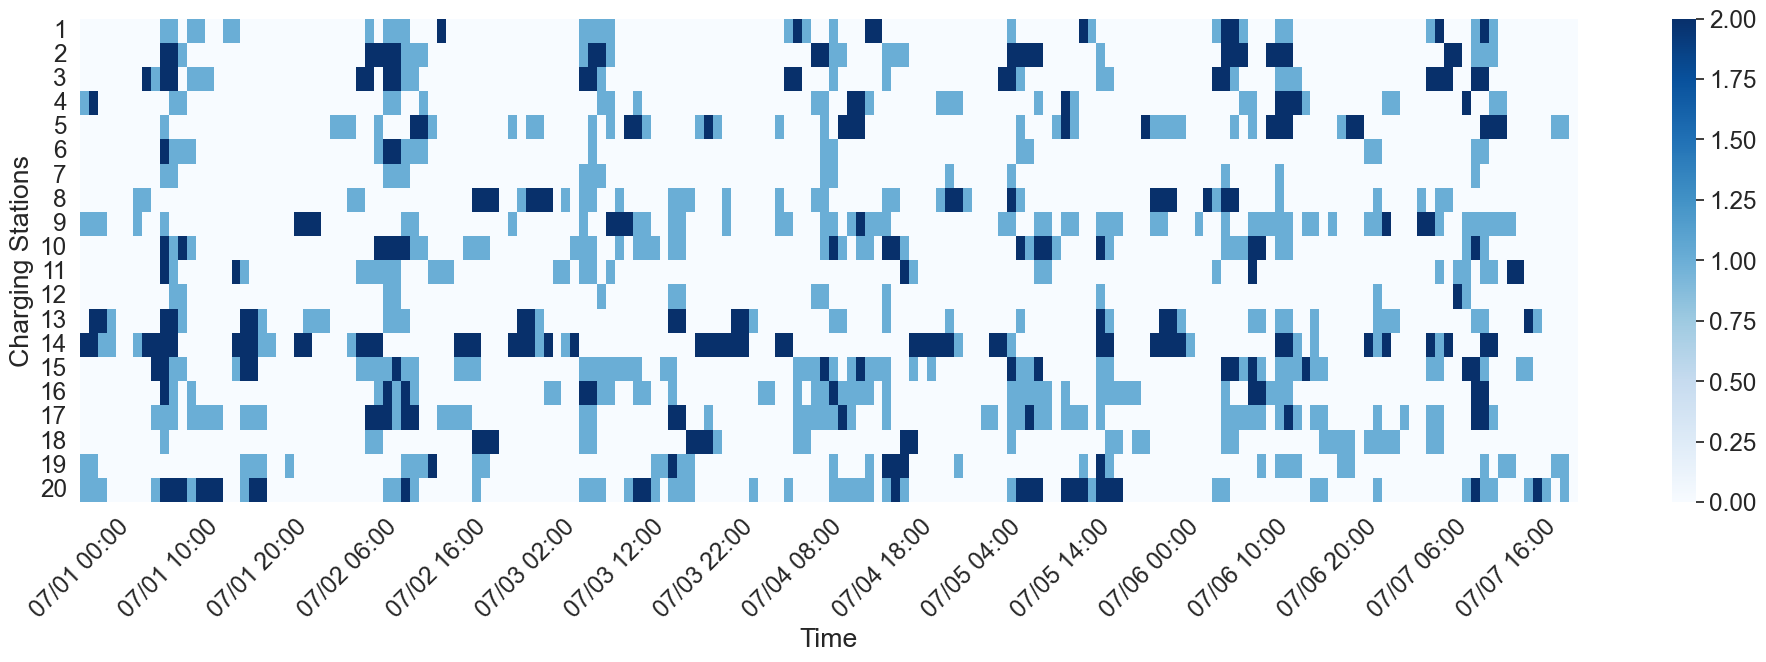

In [21]:
sns.set(rc={'figure.figsize':(20, 7)}, font_scale=1.6)
ax = sns.heatmap(schedule_statistic_count, vmin=0, vmax=2, cmap="Blues")
x_name = list(schedule_statistic_count.columns.strftime('%m/%d %H:00'))
# 設置刻度位置
ax.set_xticks(np.arange(0, len(x_name), 10))
ax.set_xticklabels(x_name[::10])
ax.set_yticklabels([i for i in range(1, 21)])
plt.xticks(np.arange(0, 168, step=10), rotation=45)
plt.yticks(rotation=0)
plt.xlabel("Time")
plt.ylabel("Charging Stations")
plt.tight_layout()
ax

每個充電站在七天的電力總花費、總收益(電費扣除EV收益)

In [22]:
misp_v2_statistic_df = pd.DataFrame([], columns=["locationID", "buildingID", "Total Electricity Cost", "Total Revenue"])

for locationID in schedule_electricity_cost.keys():
    misp_v2_statistic_df.loc[len(misp_v2_statistic_df)] = [locationID, 
                                                 location.loc[locationID, "buildingID"],
                                                 schedule_electricity_cost[locationID],
                                                 schedule_ev_revenue[locationID]]

misp_v2_statistic_df.set_index("locationID", inplace=True)
misp_v2_statistic_df

,buildingID,Total Electricity Cost,Total Revenue
locationID,,,
50230,0,166686.679856,4860
51199,1,160152.732379,7830
50841,2,245377.317156,6660
50692,3,108510.693422,4140
51087,4,128935.846446,6660
51198,5,133940.921783,1980
50840,6,110816.160628,1350
50349,7,259302.448693,6030
50909,8,147786.860003,6840
